In [4]:
import numpy as np
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import expon
%matplotlib inline

In [5]:
from sqlalchemy import create_engine

postgres_str = ('postgresql://localhost/crossvalidated')
cnx = create_engine(postgres_str)

In [10]:
t = pd.read_sql_query('''SELECT body FROM Posts LIMIT 5;''', cnx)
t.body[0]

'<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n'

**Various measures**

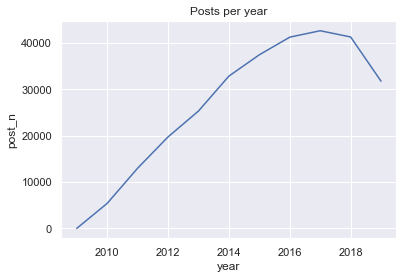

In [4]:
posts_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS Post_n
                    FROM Posts
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=posts_per_year['year'], y=posts_per_year['post_n']).set_title('Posts per year')
plt.show()

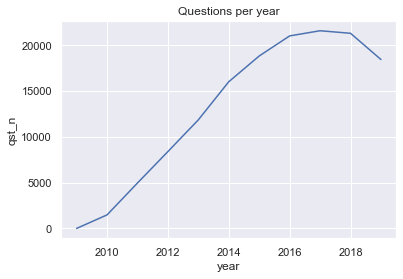

In [5]:
questions_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS qst_n
                    FROM Posts
                    WHERE PostTypeId=1
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=questions_per_year['year'], y=questions_per_year['qst_n']).set_title('Questions per year')
plt.show()

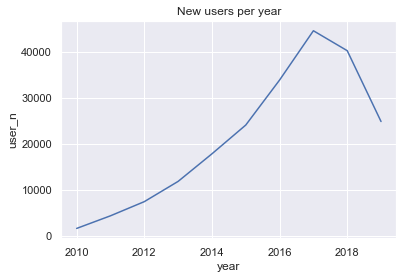

In [6]:
newusers_per_year = pd.read_sql_query(
                    '''SELECT CAST(date_part('year', CreationDate) AS INTEGER) AS Year, COUNT(*) AS User_n
                    FROM Users
                    GROUP BY date_part('year', CreationDate);''', cnx)
sns.lineplot(x=newusers_per_year['year'], y=newusers_per_year['user_n']).set_title('New users per year')
plt.show()

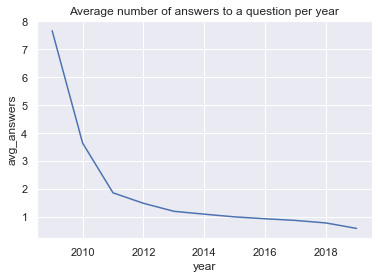

In [7]:
avg_ans_per_year = pd.read_sql_query(
        '''SELECT Year, AVG(c_answers) AS Avg_answers FROM (
        SELECT Q.Id, CAST(date_part('year', Q.CreationDate) AS INTEGER) AS Year, COUNT(Ans.Id) AS c_answers
        FROM Posts AS Q LEFT JOIN Posts AS Ans ON Q.Id=Ans.ParentId
        WHERE Q.PostTypeId=1
        GROUP BY Q.Id) AS anstable
        GROUP BY Year
        ORDER BY Year ASC;''', cnx)
sns.lineplot(x=avg_ans_per_year['year'], y=avg_ans_per_year['avg_answers']).set_title('Average number of answers to a question per year')
plt.show()

In [8]:
print("Percentage of users that wrote more than x answers:")
for i in [1,2,5,10]:
    avg_ans_per_year = pd.read_sql_query(
            '''with countPerUser as (Select OwnerUserId, count(OwnerUserId) as c from Posts where ParentId is not null group by OwnerUserId)
    Select (Select CAST(Count(c) AS float) from countPerUser where c>%i)/CAST(Count(c) AS float) from countPerUser'''%i, cnx)
    print("Users with more than ", i, " answers: ", avg_ans_per_year.values[0,0]*100)

Percentage of users that wrote more than x answers:
Users with more than  1  answers:  36.4093059552261
Users with more than  2  answers:  24.2110910598449
Users with more than  5  answers:  12.8469004535922
Users with more than  10  answers:  7.48183192703507


In [9]:
print("Percentage of users that wrote more than x questions:")
for i in [1,2,5,10]:
    avg_ans_per_year = pd.read_sql_query(
            '''with countPerUser as (Select OwnerUserId, count(OwnerUserId) as c from Posts where ParentId is null group by OwnerUserId)
    Select (Select CAST(Count(c) AS float) from countPerUser where c>%i)/CAST(Count(c) AS float) from countPerUser'''%i, cnx)
    print("Users with more than ", i, " question: ", avg_ans_per_year.values[0,0]*100)

Percentage of users that wrote more than x questions:
Users with more than  1  question:  31.7843485923804
Users with more than  2  question:  17.893842352904098
Users with more than  5  question:  6.5227312068233
Users with more than  10  question:  2.61223975954805


In [10]:
time_to_acc_ans = pd.read_sql_query(
        '''SELECT Q.Id, Q.CreationDate, (Ans.CreationDate - Q.CreationDate) AS TimeToAns
        FROM Posts AS Q LEFT JOIN Posts AS Ans ON Q.AcceptedAnswerId=Ans.Id
        WHERE Q.PostTypeId=1;''', cnx)

In [11]:
time_to_acc_ans['timetoans_bin'] = 'never'
time_to_acc_ans.loc[time_to_acc_ans['timetoans'] <= pd.Timedelta('1 hour'), 'timetoans_bin'] = '<1 hour'
time_to_acc_ans.loc[
    (time_to_acc_ans['timetoans'] > pd.Timedelta('1 hour')) & (time_to_acc_ans['timetoans'] <= pd.Timedelta('1 day')),
    'timetoans_bin'] = '<1 day'
time_to_acc_ans.loc[
    (time_to_acc_ans['timetoans'] > pd.Timedelta('1 day')) & (time_to_acc_ans['timetoans'] <= pd.Timedelta('7 days')),
    'timetoans_bin'] = '<1 week'
time_to_acc_ans.loc[
    (time_to_acc_ans['timetoans'] > pd.Timedelta('7 days')) & (time_to_acc_ans['timetoans'] <= pd.Timedelta('30 days')),
    'timetoans_bin'] = '<1 month'
time_to_acc_ans.loc[
    (time_to_acc_ans['timetoans'] > pd.Timedelta('30 days')) & (time_to_acc_ans['timetoans'] <= pd.Timedelta('365 days')),
    'timetoans_bin'] = '<1 year'
time_to_acc_ans.loc[time_to_acc_ans['timetoans'] > pd.Timedelta('365 days'), 'timetoans_bin'] = '>1 year'

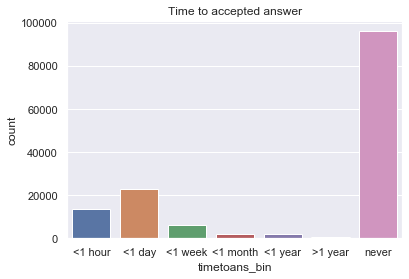

In [12]:
sns.countplot(x="timetoans_bin", data=time_to_acc_ans, order=['<1 hour', '<1 day', '<1 week', '<1 month', '<1 year', '>1 year', 'never']).set_title('Time to accepted answer')
plt.show()

In [13]:
time_to_first_ans = pd.read_sql_query(
        '''SELECT Q.Id, Q.CreationDate, MIN(Ans.CreationDate - Q.CreationDate) AS TimeToAns
        FROM Posts AS Q LEFT JOIN Posts AS Ans ON Q.Id=Ans.ParentId
        WHERE Q.PostTypeId=1
        GROUP BY Q.Id;''', cnx)

In [14]:
time_to_first_ans['timetoans_bin'] = 'never'
time_to_first_ans.loc[time_to_first_ans['timetoans'] <= pd.Timedelta('1 hour'), 'timetoans_bin'] = '<1 hour'
time_to_first_ans.loc[
    (time_to_first_ans['timetoans'] > pd.Timedelta('1 hour')) & (time_to_first_ans['timetoans'] <= pd.Timedelta('1 day')),
    'timetoans_bin'] = '<1 day'
time_to_first_ans.loc[
    (time_to_first_ans['timetoans'] > pd.Timedelta('1 day')) & (time_to_first_ans['timetoans'] <= pd.Timedelta('7 days')),
    'timetoans_bin'] = '<1 week'
time_to_first_ans.loc[
    (time_to_first_ans['timetoans'] > pd.Timedelta('7 days')) & (time_to_first_ans['timetoans'] <= pd.Timedelta('30 days')),
    'timetoans_bin'] = '<1 month'
time_to_first_ans.loc[
    (time_to_first_ans['timetoans'] > pd.Timedelta('30 days')) & (time_to_first_ans['timetoans'] <= pd.Timedelta('365 days')),
    'timetoans_bin'] = '<1 year'
time_to_first_ans.loc[time_to_first_ans['timetoans'] > pd.Timedelta('365 days'), 'timetoans_bin'] = '>1 year'

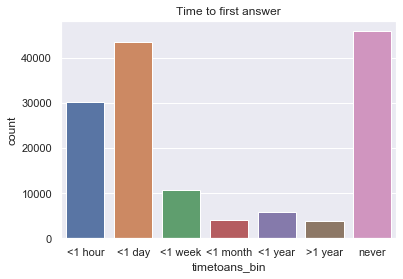

In [15]:
sns.countplot(x="timetoans_bin", data=time_to_first_ans, order=['<1 hour', '<1 day', '<1 week', '<1 month', '<1 year', '>1 year', 'never']).set_title('Time to first answer')
plt.show()

In [16]:
time_to_first_ans.groupby(['creationyear', 'timetoans_bin']).size().reset_index()\
    .pivot(index='timetoans_bin', columns='creationyear', values=0)\
    .reindex(['<1 hour', '<1 day', '<1 week', '<1 month', '<1 year', '>1 year', 'never']).T\
    .plot(kind='bar', stacked=True).set_title('Time to first answer over the years')
plt.show()

KeyError: 'creationyear'

## Time between first answer and accepted Answer

In [31]:
# time first answer to accepted answer Q.Id, Q.CreationDate, MIN(Ans.CreationDate - Q.CreationDate) AS TimeToAns
q = '''SELECT Q.Id as qid, Accepted_Ans.CreationDate - MIN(Ans.CreationDate) as first_ans_to_accepted_ans, EXTRACT(YEAR FROM Q.CreationDate) as creationyear
        FROM Posts AS Q INNER JOIN Posts AS Ans ON Q.Id=Ans.ParentId
        LEFT JOIN Posts AS Accepted_Ans on Q.AcceptedAnswerId = Accepted_Ans.Id
        WHERE Q.PostTypeId=1 GROUP BY Q.Id, Accepted_Ans.CreationDate
        '''
first_to_accepted_answer = pd.read_sql_query(q, cnx)

In [32]:
def extend_df_with_timebins(df, colname):
    bin_col_name = "{}_bin".format(colname)
    
    df[bin_col_name] = 'never'
    df.loc[df[colname] == pd.Timedelta(0), bin_col_name] = 'same'
    df.loc[(df[colname] <= pd.Timedelta('1 hour')) & (df[colname] != pd.Timedelta(0)),
           bin_col_name] = '<1 hour'
    df.loc[
        (df[colname] > pd.Timedelta('1 hour')) & (df[colname] <= pd.Timedelta('1 day')),
        bin_col_name] = '<1 day'
    df.loc[
        (df[colname] > pd.Timedelta('1 day')) & (df[colname] <= pd.Timedelta('7 days')),
        bin_col_name] = '<1 week'
    df.loc[
        (df[colname] > pd.Timedelta('7 days')) & (df[colname] <= pd.Timedelta('30 days')),
        bin_col_name] = '<1 month'
    df.loc[
        (df[colname] > pd.Timedelta('30 days')) & (df[colname] <= pd.Timedelta('365 days')),
        bin_col_name] = '<1 year'
    df.loc[df[colname] > pd.Timedelta('365 days'), bin_col_name] = '>1 year'
    return df

In [33]:
first_to_accepted_with_bins = extend_df_with_timebins(first_to_accepted_answer, "first_ans_to_accepted_ans")
#first_to_accepted_with_bins

Text(0.5, 1.0, 'Time from first answer to accepted answer')

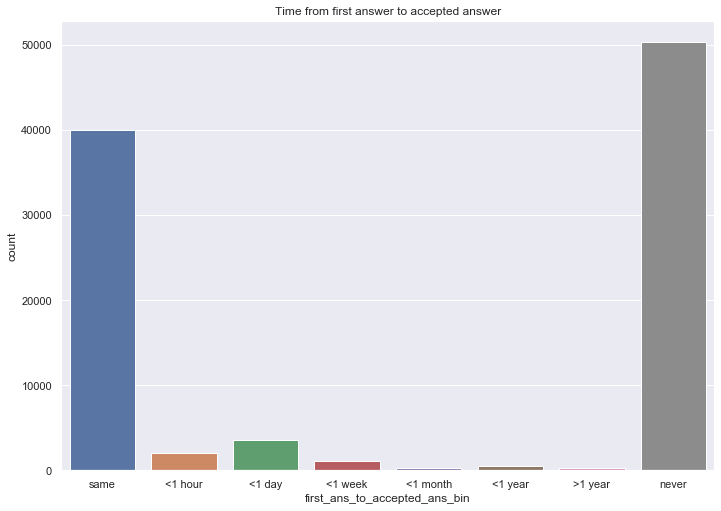

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x="first_ans_to_accepted_ans_bin", 
              data=first_to_accepted_with_bins, 
              order=['same', '<1 hour', '<1 day', '<1 week', '<1 month', '<1 year', '>1 year', 'never']).set_title('Time from first answer to accepted answer')

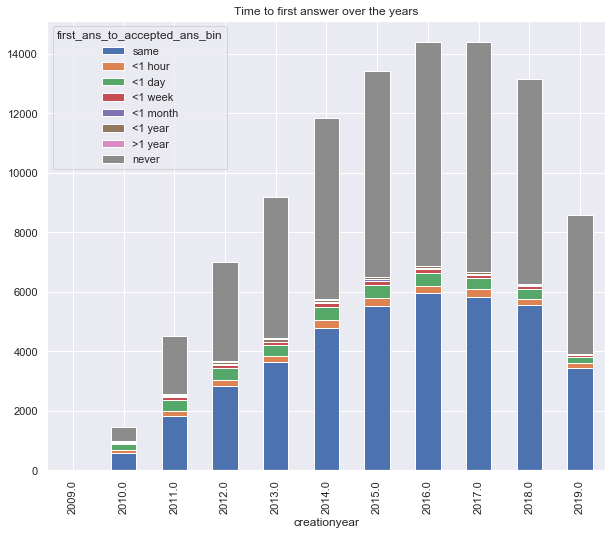

In [43]:
first_to_accepted_with_bins.groupby(['creationyear', 'first_ans_to_accepted_ans_bin']).size().reset_index()\
    .pivot(index='first_ans_to_accepted_ans_bin', columns='creationyear', values=0)\
    .reindex(['same', '<1 hour', '<1 day', '<1 week', '<1 month', '<1 year', '>1 year', 'never']).T\
    .plot(kind='bar', stacked=True, figsize=(10,8.27)).set_title('Time to first answer over the years')
plt.show()

In [ ]:
## Users Age when they answer questions

In [21]:
q = """
    SELECT A.ParentId as question_id, U.Id as answerer_id, COALESCE(A.Id = Q.AcceptedAnswerId, FALSE) accepted, A.CreationDate as date_of_answer, (A.CreationDate - Q.CreationDate) as age_of_question, A.CreationDate - U.CreationDate as user_age_at_answer_time
    FROM Posts A INNER JOIN Users U ON A.OwnerUserId = U.Id 
    INNER JOIN Posts Q ON A.ParentId = Q.Id
    WHERE A.PostTypeId = 2 
"""

user_age_at_answer_times = pd.read_sql_query(q, cnx)

# can be negative since some answers have a time in the database dump that is obviously wrong
# https://data.stackexchange.com/stats/query/1137375

In [22]:
#user_age_at_answer_times[user_age_at_answer_times.user_age_at_answer_time > pd.Timedelta(0)].sort_values("user_age_at_answer_time")

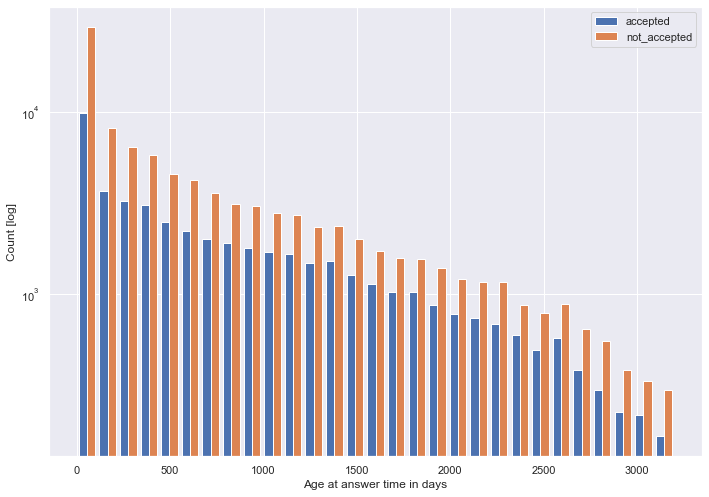

In [47]:
user_age_in_days = user_age_at_answer_times.user_age_at_answer_time / pd.Timedelta('1 day')
question_age_in_days = user_age_at_answer_times.age_of_question / pd.Timedelta('1 day')

user_age_accepted = user_age_in_days[user_age_at_answer_times.accepted]
user_age_not_accepted = user_age_in_days[np.invert(user_age_at_answer_times.accepted)]

_ = plt.hist([user_age_accepted, user_age_not_accepted], bins=np.linspace(0, 3200, 30), label=['accepted', 'not_accepted'], log=True)
plt.xlabel("Age at answer time in days")
plt.ylabel("Count [log]")
plt.legend()
# plt.scatter(x=question_age_in_days, y=user_age_in_days)

## Analyze which tags are occuring most often

In [26]:
tags = pd.read_sql_query(
        '''SELECT Tags FROM Posts''', cnx)

In [48]:
number_posts = len(tags)
none_counter = 0
tag_list = []
for t in tags.values:
    if t[0] is not None:
        tags_this_post = t[0].split("><")
        for tag in tags_this_post:
            tag = tag.replace("<", "")
            tag = tag.replace(">", "")
            tag_list.append(tag)
    else:
        none_counter+=1

In [38]:
print(len(tag_list))
unique_tags, counts = np.unique(tag_list, return_counts=True)
sorted_counts_inds = np.argsort(counts)
sorted_tags = unique_tags[sorted_counts_inds]
sorted_counts = counts[sorted_counts_inds]
print(sorted_tags[-10:], sorted_counts[-10:])

429015
['bayesian' 'logistic' 'self-study' 'distributions' 'hypothesis-testing'
 'probability' 'time-series' 'machine-learning' 'regression' 'r'] [ 5114  5195  6189  6258  6504  7656  9688 12930 18842 20528]


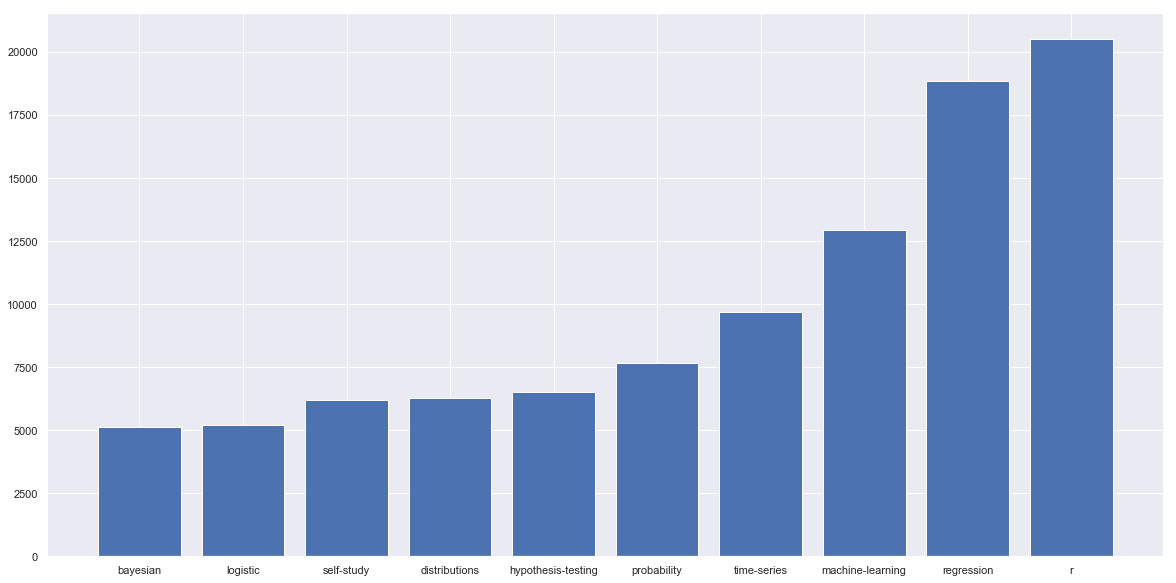

In [41]:
labels = sorted_tags[-10:]
data = sorted_counts[-10:]

plt.figure(figsize=(20,10))
plt.bar(np.arange(1,11,1), data)
plt.xticks(np.arange(1,11,1), labels)
plt.show()

### Further information about tags:

In [51]:
print("NUMBER OF DIFFERENT TAGS:", len(unique_tags))
print("PERCENTAGE OF TAGS OCCURING MORE THAN ONCE: ", 100*len(unique_tags[counts>1])/len(unique_tags), "%")
print("PERCENTAGE OF TAGS OCCURING MORE THAN 100 TIMES: ", 100*len(unique_tags[counts>100])/len(unique_tags), "%")
print("PERCENTAGE OF POSTS WITHOUT ANY TAGS:", 100*none_counter/number_posts)

NUMBER OF DIFFERENT TAGS: 1428
PERCENTAGE OF TAGS OCCURING MORE THAN ONCE:  97.40896358543418 %
PERCENTAGE OF TAGS OCCURING MORE THAN 100 TIMES:  38.65546218487395 %
PERCENTAGE OF POSTS WITHOUT ANY TAGS: 50.43852396896918


# Try to fit distribution to question_creation - answer values

## Get all questionage values (for each answer, get how old the corresponding question was when it was answered)

In [8]:
questionage_table = pd.read_sql_query('''SELECT a.id, (answercreationdate-CreationDate) as questionage FROM 
(SELECT parentid as Id, creationdate as answercreationdate FROM Posts WHERE PostTypeId=2) a
LEFT JOIN Posts b ON a.Id=b.Id;''', cnx) # On AS Q LEFT JOIN Posts AS Ans
questionage_table["questionage"] = questionage_table["questionage"].dt.days +  (questionage_table["questionage"].dt.seconds)/(24*60*60)
questionage_table

,id,questionage
0,257,0.004560
1,50,0.003495
2,47,0.004954
3,32669,0.394907
4,50,0.021169
5,50,0.021586
6,114,0.002350
7,114,0.002442
8,146,0.006458
9,155,0.005914


In [16]:
pd.read_sql_query('''(SELECT parentid as Id, creationdate as answercreationdate FROM Posts WHERE PostTypeId=2 LIMIT 5);''', cnx)

,id,answercreationdate
0,3,2010-07-19 19:14:43.050
1,3,2010-07-19 19:16:27.553
2,7,2010-07-19 19:18:41.370
3,6,2010-07-19 19:18:56.800
4,3,2010-07-19 19:19:03.990


In [9]:
age_vals = questionage_table["questionage"].values
age_vals = age_vals[age_vals>0]

### Plot the values

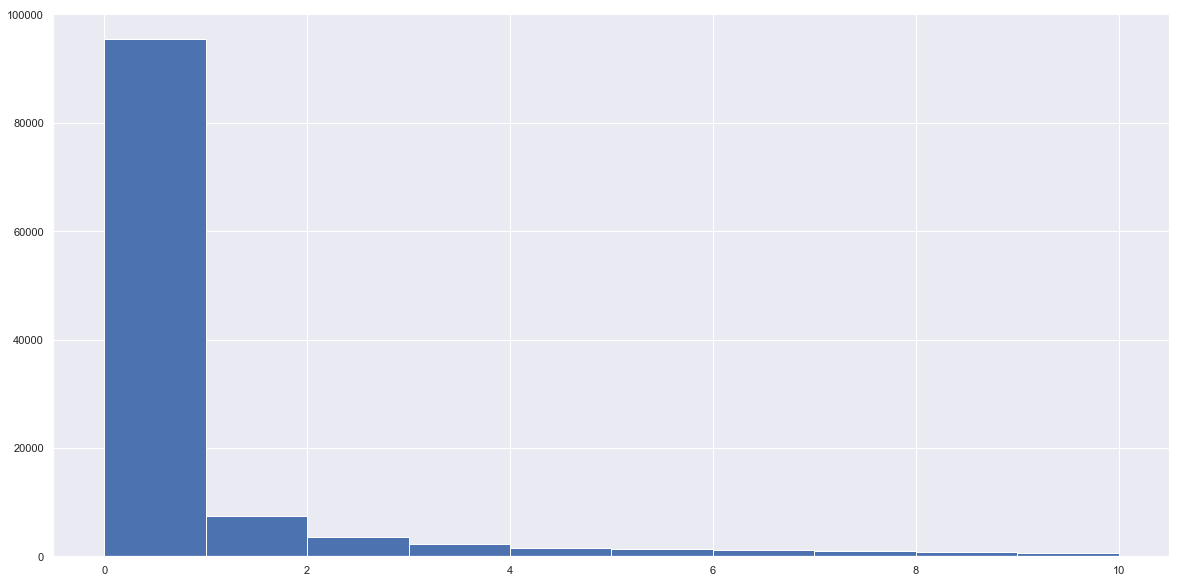

In [43]:
plt.figure(figsize=(20,10))
plt.hist(age_vals[age_vals<10])
plt.show()

### Fit scipy distributions

In [22]:
import scipy.stats as st

(-0.3530395997092245, 1.3032193696909253)


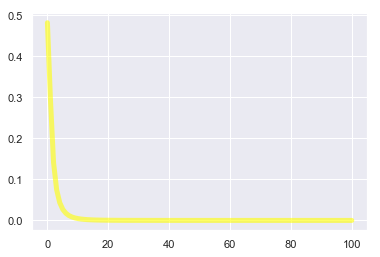

In [55]:
params = st.gilbrat.fit(age_vals[age_vals<500].astype(np.float64))
print(params)
plt.plot(x, eval(dist).pdf(x, params[0], params[1]),'r-', lw=5, alpha=0.6, label=dist, c=cols[i])

(0.00015046296296296297, 3.331900901581359)
(0.5253115202128518, -0.054303867206386275, 0.05445363409925952)
(0.1537257316521411, 0.00015046296296296295, 140.35114242000958)
(-0.10527790478967086, 0.47155014331891454)


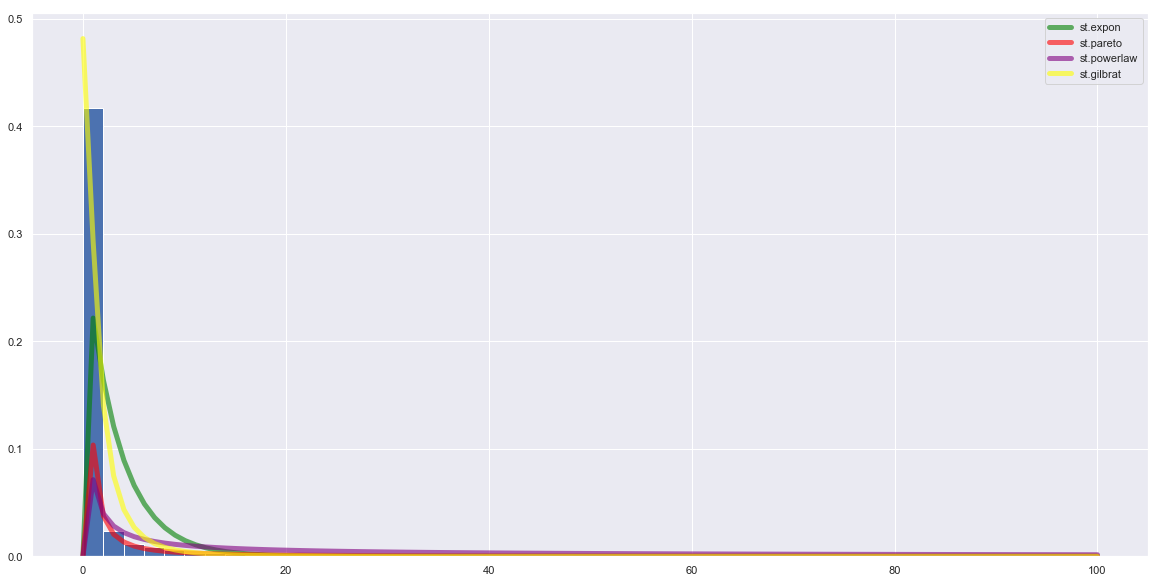

In [57]:
cols = ["green", "red", "purple", "yellow"]
plt.figure(figsize=(20,10))
plt.hist(age_vals[age_vals<100], bins=50, density=True)
for i, dist in enumerate(["st.expon", "st.pareto", "st.powerlaw", "st.gilbrat"]):
    params = eval(dist).fit(age_vals[age_vals<100].astype(np.float64))
    print(params)
    if dist == "st.gilbrat":
        params = (-0.3530395997092245, 1.3032193696909253)
    x = np.linspace(0, 100, 100)
    # plt.plot(x, st.gilbrat.pdf(x, params[0], params[1]),'r-', lw=5, alpha=0.6, label='expon pdf')
    if len(params)==2:
        plt.plot(x, eval(dist).pdf(x, params[0], params[1]),'r-', lw=5, alpha=0.6, label=dist, c=cols[i])
    elif len(params)==3:
        plt.plot(x, eval(dist).pdf(x, params[0], params[1], params[2]),'r-', lw=5, alpha=0.6, label=dist, c=cols[i])
plt.legend()
plt.show()

### Code to iterate through all distributions (did not work for me, copied from stackoverflow)

In [ ]:
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

            # fit dist to data
        params = distribution.fit(data)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))

        # if axis pass in add to plot
        try:
            if ax:
                pd.Series(pdf, x).plot(ax=ax)
            end
        except Exception:
            pass

        # identify if this distribution is better
        if best_sse > sse > 0:
            best_distribution = distribution
            best_params = params
            best_sse = sse
            print(best_params)

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = age_vals

# Plot for comparison
plt.figure(figsize=(12,8))
ax = plt.hist(data, bins=50)
# Save plot limits

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

print(best_dist, best_fit_params)
# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
# data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)
plt.hist(data, bins=50)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')